# Data Prep

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(".."))

In [1]:
shares = [2,3,4,2,5]

shares_norm = shares / 10

print(shares_norm)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [2]:
from src.preprocess.preprocessor import get_df
from src.config_training import TrainSettings

settings = TrainSettings()

TRAIN_START_DATE = settings.TRAIN_START_DATE
TRAIN_END_DATE = settings.TRAIN_END_DATE
VAL_START_DATE = settings.VAL_START_DATE
VAL_END_DATE = settings.VAL_END_DATE

TEST23_START_DATE = settings.TEST23_START_DATE
TEST23_END_DATE = settings.TEST23_END_DATE
TEST24_START_DATE = settings.TEST24_START_DATE
TEST24_END_DATE = settings.TEST24_END_DATE

INDICATORS = settings.INDICATORS

df_train = get_df(TRAIN_START_DATE, TRAIN_END_DATE, "../src/preprocess/tickers/ticker_lists.json")
df_val = get_df(VAL_START_DATE, VAL_END_DATE, "../src/preprocess/tickers/ticker_lists.json")
df_test23 = get_df(TEST23_START_DATE, TEST23_END_DATE, "../src/preprocess/tickers/ticker_lists.json")
df_test24 = get_df(TEST24_START_DATE, TEST24_END_DATE, "../src/preprocess/tickers/ticker_lists.json")
stock_dimension = len(df_train.tic.unique())


From: 2017-12-02 00:00:00
To: 2022-01-01
Shape of DataFrame:  (30810, 8)
Successfully added technical indicators
From: 2021-12-02 00:00:00
To: 2023-01-01
Shape of DataFrame:  (8160, 8)
Successfully added technical indicators
From: 2022-12-02 00:00:00
To: 2024-01-01
Shape of DataFrame:  (8100, 8)
Successfully added technical indicators
From: 2023-12-02 00:00:00
To: 2025-01-01
Shape of DataFrame:  (8130, 8)
Successfully added technical indicators


# HRL

In [3]:
#OPTUNA
from hyperparameter_searching.HRL_optuna_utils import hyperparams_opt_HRL
N_TRIALS = 40
hrl_opt = hyperparams_opt_HRL(
    df_train=df_train, df_test=df_val, indicators=INDICATORS, n_trials=N_TRIALS
)
hrl_opt.run_opt()

day: 1007, episode: 18
begin_total_asset: 1000000.00
end_total_asset: 1641497.41
total_reward: 641497.41
total_cost: 25202.32
total_trades: 7757
Sharpe: 0.635
day: 1007, episode: 19
begin_total_asset: 1000000.00
end_total_asset: 1676661.18
total_reward: 676661.18
total_cost: 25697.96
total_trades: 9728
Sharpe: 0.629
day: 1007, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1501787.13
total_reward: 501787.13
total_cost: 23959.47
total_trades: 9453
Sharpe: 0.507
day: 1007, episode: 21
begin_total_asset: 1000000.00
end_total_asset: 1476079.62
total_reward: 476079.62
total_cost: 24175.44
total_trades: 9189
Sharpe: 0.482
day: 1007, episode: 22
begin_total_asset: 1000000.00
end_total_asset: 1516459.97
total_reward: 516459.97
total_cost: 25120.67
total_trades: 9138
Sharpe: 0.510
day: 1007, episode: 23
begin_total_asset: 1000000.00
end_total_asset: 1643801.73
total_reward: 643801.73
total_cost: 28730.97
total_trades: 8787
Sharpe: 0.573
day: 1007, episode: 24
begin_total_asset: 1000

[I 2025-12-16 09:57:52,018] Trial 1 finished with value: 683248.3599976574 and parameters: {'lr_actor_M': 0.00045084023484830713, 'lr_critic_M': 0.0009494204170968856, 'gamma_M': 0.9935060478574778, 'update_timestep': 4096, 'gamma_W': 0.9972340698003559, 'lr_W': 0.00044649041897470233, 'buffer_size': 40000, 'batch_size': 1024}. Best is trial 0 with value: 990977.7017406926.


Starting Phase 1: Only train Manager
day: 1007, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 1187549.08
total_reward: 187549.08
total_cost: 86664.77
total_trades: 17191
Sharpe: 0.296
day: 1007, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 990352.60
total_reward: -9647.40
total_cost: 76200.00
total_trades: 16821
Sharpe: 0.148
day: 1007, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 1345717.34
total_reward: 345717.34
total_cost: 88765.91
total_trades: 17563
Sharpe: 0.452
day: 1007, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 1084918.49
total_reward: 84918.49
total_cost: 83781.98
total_trades: 17214
Sharpe: 0.205
day: 1007, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1461784.47
total_reward: 461784.47
total_cost: 95005.82
total_trades: 17839
Sharpe: 0.548
day: 1007, episode: 6
begin_total_asset: 1000000.00
end_total_asset: 1003060.15
total_reward: 3060.15
total_cost: 84442.45
total_trades: 17101
Sharpe: 0.152
day: 1007, epi

[W 2025-12-16 10:11:22,194] Trial 2 failed with parameters: {'lr_actor_M': 6.357889562858175e-05, 'lr_critic_M': 0.00044896596708690975, 'gamma_M': 0.9894136526241157, 'update_timestep': 4096, 'gamma_W': 0.9807386751515403, 'lr_W': 0.00022836214249326813, 'buffer_size': 40000, 'batch_size': 128} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\andoni.iribarren\Desktop\TFM\HRL_MAML_StockTrading\hrlenv\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\andoni.iribarren\Desktop\TFM\HRL_MAML_StockTrading\src\hyperparameter_searching\HRL_optuna_utils.py", line 114, in objective
    trained_model = model.train_HRL_model()
                    ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\andoni.iribarren\Desktop\TFM\HRL_MAML_StockTrading\src\agent\HRL_model.py", line 278, in train_HRL_model
    self.alternate_training()
  File "c:\Users\and

KeyboardInterrupt: 

## Training

In [4]:
# TRAINING with BEST HPs
from env_stocktrading.trading_env_HRL import StockTradingEnvHRL
from agent.HRL_model import HRLAgent

episode_len = df_train.dayorder.nunique()
state_space_manager = stock_dimension + len(INDICATORS) * stock_dimension
state_space_worker = 1 + 3 * stock_dimension

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

hrl_train_env = StockTradingEnvHRL(
    df=df_train,
    stock_dim=stock_dimension,
    hmax=100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space_M=state_space_manager,
    state_space_W=state_space_worker,
    action_space=stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=False,
    print_verbosity=1,
)

best_params = settings.best_hiperparams_HRL

best_params_manager = {
    "lr_actor": best_params["lr_actor_M"],
    "lr_critic": best_params["lr_critic_M"],
    "gamma": best_params["gamma_M"],
    "K_epochs": 80,
    "eps_clip": 0.2,
    "update_timestep": best_params["update_timestep"],
}

best_params_worker = {
    "learning_rate": best_params["lr_W"],
    "tau": 0.005,
    "buffer_size": best_params["buffer_size"],
    "batch_size": best_params["batch_size"],
    "gamma": best_params["gamma_W"],
    "verbose": 1,
}

initial_manager_episodes = 10#40
initial_worker_episodes = 10#40
initial_cycle_episodes = 5#10
n_cycles = 2#16

model = HRLAgent(
    env=hrl_train_env,
    stock_dim=stock_dimension,
    manager_kwargs=best_params_manager,
    worker_kwargs=best_params_worker,
    initial_manager_timesteps=initial_manager_episodes * episode_len,  # initial_manager_episodes
    initial_worker_timesteps=initial_worker_episodes * episode_len,   # initial_worker_episodes
    n_alt_cycles=n_cycles,                                              # n_cycles
    initial_cycle_steps=initial_cycle_episodes * episode_len,        # initial_cycle_episodes
)

trained_model = model.train_HRL_model()

Device set to : cpu
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting Phase 1: Only train Manager
DEBUG 1:  {'full_state': [8.410348928279745, 173.9215545654297, 198.1446533203125, 166.7169952392578, 155.59222412109375, 201.32000732421875, 191.91696166992188, 251.48460388183594, 56.28336715698242, 99.85714721679688, 152.3502197265625, 345.6678466796875, 375.0969543457031, 180.5004425048828, 114.13739013671875, 152.15887451171875, 142.56716918945312, 52.547183990478516, 244.62106323242188, 127.44898986816406, 68.34442901611328, 325.41748046875, 156.3751678466797, 29.35413932800293, 147.97491455078125, 339.4993896484375, 144.68402099609375, 469.3490295410156, 210.2762451171875, 40.25408935546875, 45.871376037597656, 306.0, 366.0, 830.0, 93.0, 88.0, 215.0, 61.0, 59.0, 11.0, 0.0, 0.0, 51.0, 672.0, 477.0, 87.0, 639.0, 1007.0, 136.0, 751.0, 0.0, 751.0, 1211.0, 2396, 378.0, 254.0, 0.0, 4.0, 191.0, 3.0, 1013.0, 2.0543905255502883, 1.52026741

In [5]:
# VALIDATION
hrl_val_env = StockTradingEnvHRL(
    df=df_val,
    stock_dim=stock_dimension,
    hmax=100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space_M=state_space_manager,
    state_space_W=state_space_worker,
    action_space=stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=False,
    print_verbosity=1,
)

df_account_value_hrl, df_actions_hrl, last_state_hrl = trained_model.predictHRL(hrl_val_env)

Retrieving memory from env...
DEBUG 1:  {'full_state': [8.691404224375447, 127.99897766113281, 238.62937927246094, 84.0, 142.34054565429688, 190.49000549316406, 227.61123657226562, 131.20977783203125, 43.64057159423828, 158.23594665527344, 85.45539093017578, 318.4602355957031, 292.6649475097656, 189.34996032714844, 126.27813720703125, 161.2501678466797, 124.5448989868164, 58.12221145629883, 245.86402893066406, 89.69051361083984, 102.12120056152344, 234.22003173828125, 110.96204376220703, 14.599385261535645, 140.50518798828125, 230.9854736328125, 177.12400817871094, 501.90447998046875, 203.11691284179688, 32.19456481933594, 45.65860366821289, 0, 0, 0, 0, 100, 0, 0, 0, 0, 3148.0, 0, 0.0, 59.0, 0, 0, 0.0, 0.0, 0, 0, 0, 0, 0, 13.0, 0, 0, 0, 1148.0, 0, 0, 0, -1.2209947177396707, -1.589065324558365, -0.303517140082512, -0.37068442869178175, 0.9943837555654773, 0.5793845236344509, -0.2679877852894925, 0.4616975592317793, -0.3880410658873006, -0.4050373910788981, -0.7491158324909499, 0.6187540

In [6]:
# AÑO 2023
test23_env = StockTradingEnvHRL(
    df = df_test23,
    stock_dim=stock_dimension,
    hmax=100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space_M=state_space_manager,
    state_space_W=state_space_worker,
    action_space=stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=False,
    print_verbosity=1,
)

df_account_test23_HRL, df_actions_test23_HRL, last_state_test23_HRL = trained_model.predictHRL(test23_env)

df_account_test23_HRL.to_csv("../demo/results/dfs/cuenta_test23_HRL.csv")
print(last_state_test23_HRL[31:61])

Retrieving memory from env...
DEBUG 1:  {'full_state': [75.37999438685185, 190.728759765625, 270.7591857910156, 151.94000244140625, 183.15037536621094, 260.6600036621094, 286.6736145019531, 260.40081787109375, 47.69737243652344, 136.6641082763672, 89.09891510009766, 369.1131591796875, 330.03643798828125, 189.3858184814453, 153.86837768554688, 147.41748046875, 162.68890380859375, 55.544769287109375, 282.8960876464844, 86.70552825927734, 103.15250396728516, 370.515625, 104.28913879394531, 49.494422912597656, 139.30010986328125, 306.5769348144531, 184.0846710205078, 505.8956604003906, 256.5528564453125, 33.06806945800781, 51.540096282958984, 0, 0, 0, 0, 99, 0, 0, 0, 0, 4879.0, 0, 0.0, 14.0, 0, 0, 0.0, 414.0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 992.0, 0, 0, 0, 0.017070722738057424, 1.173277305124242, 0.6271659538363213, 1.9519042796979353, 2.0999858984480513, 2.1418557091356587, 1.7334361143407577, 0.0798560660630983, 0.8984284434174092, 0.08310550776644414, 2.4427006686578387, 2.027633734960308,

In [4]:
df_train

,date,close,tic,day,macd,rsi_30,cci_30,dayorder
0,2018-01-02,-1.023234,AAPL,1,-0.484252,-0.256873,-0.633457,0
1,2018-01-02,-1.486411,AMGN,1,-0.175465,-0.427605,-0.200430,0
2,2018-01-02,-1.556484,AMZN,1,-0.300346,1.439119,0.436512,0
3,2018-01-02,-0.883276,AXP,1,-0.169939,-0.241697,-0.098010,0
4,2018-01-02,0.064474,BA,1,0.248762,2.808140,0.577182,0
...,...,...,...,...,...,...,...,...
30235,2021-12-31,1.605614,TRV,4,0.199090,-0.071168,0.333957,1007
30236,2021-12-31,2.884426,UNH,4,2.568617,1.748995,0.653628,1007
30237,2021-12-31,1.088484,V,4,0.778649,-0.389478,0.446977,1007
30238,2021-12-31,0.094660,VZ,4,0.384334,-0.380111,0.359259,1007


In [10]:
# AÑO 2024
test24_env = StockTradingEnvHRL(
    df = df_test24,
    stock_dim=stock_dimension,
    hmax=100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space_M=state_space_manager,
    state_space_W=state_space_worker,
    action_space=stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=False,
    print_verbosity=1,
)

df_account_test24_HRL, df_actions_test24_HRL, last_state_test24_HRL = trained_model.predictHRL(test24_env)

df_account_test24_HRL.to_csv("../demo/results/dfs/cuenta_test24_HRL.csv")
print(last_state_test24_HRL[31:61])

Retrieving memory from env...
day: 251, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 1247051.69
total_reward: 247051.69
total_cost: 38677.31
total_trades: 2517
Sharpe: 1.625
Retrieving memory from env...
Hit end!
[97.0, 908.0, 2477.0, 0, 0.0, 0.0, 0, 0.0, 0, 100.0, 83.0, 0.0, 0, 0.0, 0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0, 13.0, 0, 0.0, 1440.0, 100.0, 0, 1.0, 0]


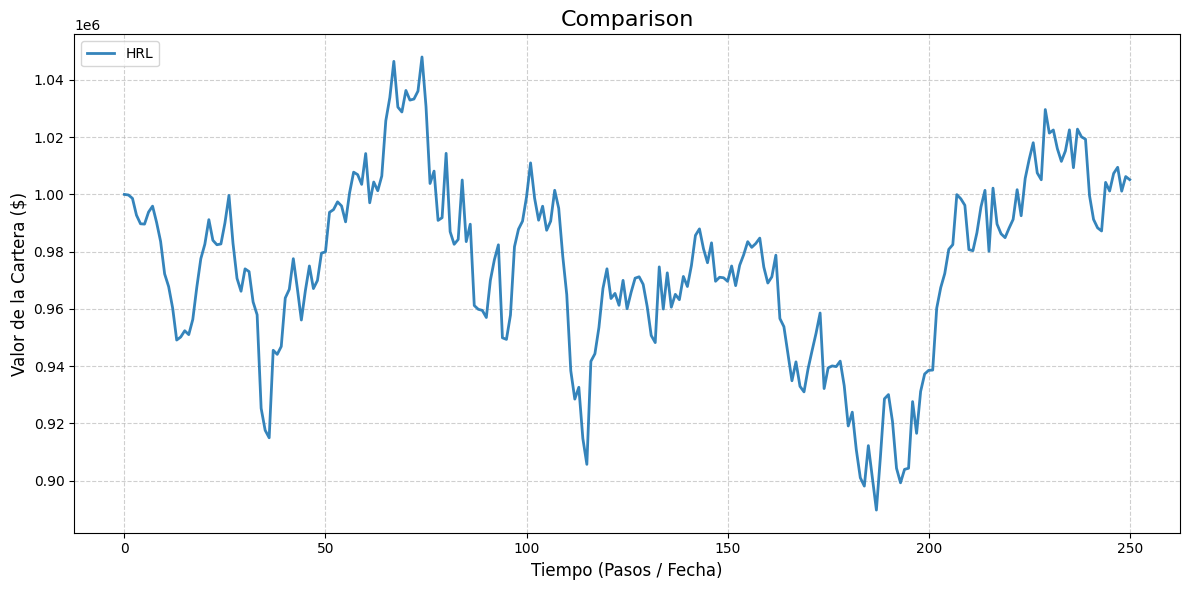

In [6]:
from eval.evaluate_functions import plot_portfolio_evolution, calculate_portfolio_metrics
%matplotlib inline
df_list = [df_account_value_hrl]
label_list = ["HRL"]
plot_portfolio_evolution(df_list, label_list)


In [7]:
calculate_portfolio_metrics(df_account_value_hrl, last_state_hrl[31:61])

KeyError: slice(31, 61, None)